In [240]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader

scaler = GradScaler()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
df_old = pd.read_csv('df_261_yahoo_starting_9_07.csv')

In [109]:
df_source = pd.read_csv('df_261_yahoo_starting_9_07.csv')
del df_source['Datetime']


In [9]:
def create_time_embeddings(df, datetime_col):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df['minute'] = df[datetime_col].dt.minute + df[datetime_col].dt.hour * 60
    df['hour'] = df[datetime_col].dt.hour
    df['day'] = df[datetime_col].dt.day
    df['day_of_week'] = df[datetime_col].dt.dayofweek
    df['week'] = df[datetime_col].dt.isocalendar().week
    df['month'] = df[datetime_col].dt.month

    return df 

In [13]:
df_old.ffill(inplace=True)
df_old = df_old.mask(df_old == 0).ffill()
df_old.index = df_old['Datetime']

df_old = create_time_embeddings(df_old, 'Datetime')
del df_old['Datetime']
df_old = df_old.apply(lambda x: (x - np.mean(x)) / np.std(x))

df_old = df_old.apply(pd.to_numeric, errors='coerce')
df_old.ffill(inplace=True)

# Convert all columns to float, if possible
for col in df_old.columns:
    try:
        df_old[col] = df_old[col].astype(float)
    except ValueError:
        print(f"Column '{col}' cannot be converted to float.")

# Fill NaN values
df_old.fillna(0, inplace=True)

# Try creating the tensor again
try:
    tensor = torch.tensor(df_old.values, dtype=torch.float32)
except TypeError as e:
    print(f"Tensor conversion error: {e}")

In [20]:
df_old

,AAL,AAP,AAPL,ABT,ADBE,ADI,ADP,ADSK,AEP,AKAM,...,BITO,JNPR,PINS,UNG,minute,hour,day,day_of_week,week,month
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-09-07 09:30:00-04:00,1.915927,2.827478,0.031408,1.592126,1.173970,1.447934,0.989300,1.996726,0.437159,-0.581046,...,-0.985740,1.697089,0.397783,-1.762539,-1.709953,-1.711574,-1.025444,0.652730,-1.760367,-1.102235
2023-09-07 09:35:00-04:00,1.899841,2.732050,0.570477,1.545876,1.066612,1.496865,0.945660,1.820899,0.384851,-0.379371,...,-0.973286,1.681277,0.421320,-1.692106,-1.665566,-1.711574,-1.025444,0.652730,-1.760367,-1.102235
2023-09-07 09:40:00-04:00,1.907938,2.755001,0.590508,1.465311,1.169095,1.503854,0.891852,1.876465,0.365013,-0.054451,...,-0.956986,1.739141,0.495292,-1.593501,-1.621179,-1.711574,-1.025444,0.652730,-1.760367,-1.102235
2023-09-07 09:45:00-04:00,1.915821,2.701852,0.580016,1.444424,1.153170,1.346191,0.890157,1.853628,0.433551,-0.076859,...,-0.968853,1.692883,0.495292,-1.607588,-1.576792,-1.711574,-1.025444,0.652730,-1.760367,-1.102235
2023-09-07 09:50:00-04:00,1.854564,2.651119,0.339317,1.477246,0.981340,1.212604,0.886344,1.736409,0.499926,-0.200105,...,-0.981763,1.697089,0.481843,-1.634070,-1.532405,-1.711574,-1.025444,0.652730,-1.760367,-1.102235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-03 15:40:00-04:00,-0.390620,0.583135,0.375224,-0.213110,1.535618,-0.512374,-1.729508,-0.462574,1.310140,1.374077,...,1.788047,0.178990,2.610236,0.534973,1.574690,1.465053,-1.481506,1.356413,1.526388,2.204470
2023-11-03 15:45:00-04:00,-0.401274,0.563808,0.423060,-0.245933,1.506594,-0.509269,-1.737134,-0.463336,1.292105,1.374077,...,1.778267,0.195812,2.593424,0.533565,1.619077,1.465053,-1.481506,1.356413,1.526388,2.204470
2023-11-03 15:50:00-04:00,-0.427907,0.563808,0.524735,-0.244439,1.461131,-0.569849,-1.724847,-0.505580,1.292105,1.388079,...,1.788047,0.162169,2.593424,0.519478,1.663464,1.465053,-1.481506,1.356413,1.526388,2.204470


In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, seq_len_x, seq_len_y):
        """
        Custom Dataset for loading time series data.

        Parameters:
        dataframe (pd.DataFrame): DataFrame containing the time series data.
        seq_len_x (int): The length of the input sequence.
        seq_len_y (int): The length of the output/target sequence.
        """
        self.dataframe = dataframe
        self.seq_len_x = seq_len_x
        self.seq_len_y = seq_len_y

        self.tensor = torch.tensor(self.dataframe.values, dtype=torch.float32)
        self.X, self.Y = self.create_sequences(self.tensor)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def create_sequences(self, data):
        X, Y = [], []
        for i in range(len(data) - self.seq_len_x - self.seq_len_y + 1):
            X.append(data[i:i + self.seq_len_x])
            Y.append(data[i + self.seq_len_x:i + self.seq_len_x + self.seq_len_y])
        return torch.stack(X), torch.stack(Y)

In [293]:
# Usage Example
# Assuming df_old is your DataFrame, and you have set your desired sequence lengths
seq_length_x = 60
seq_length_y = 22

# Create the dataset
dataset = TimeSeriesDataset(df_old, seq_length_x, seq_length_y)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

In [92]:
y_list = []
for x, y in dataloader:
    for values in y:
        y_list.append(values[-1])

In [104]:
stock_array = []
for stock in y_list:
    stock_array.append(stock[67])

In [110]:
list(df_source.columns).index('DIA')

67

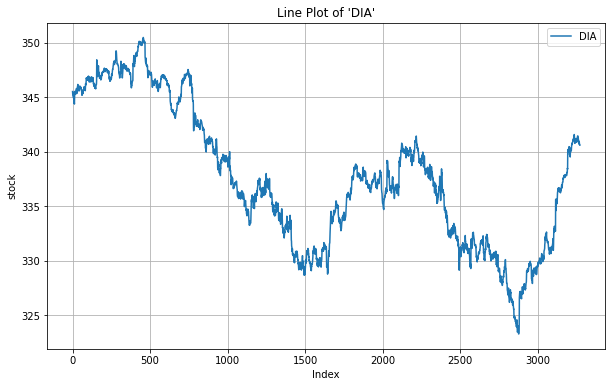

In [111]:
plt.figure(figsize=(10, 6))
plt.plot(df_source['DIA'], label='DIA')
plt.title(f"Line Plot of '{'DIA'}'")
plt.xlabel("Index")
plt.ylabel('stock')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
stock_array

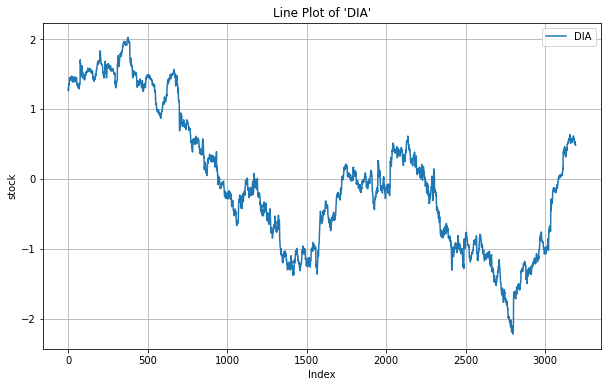

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(stock_array, label='DIA')
plt.title(f"Line Plot of '{'DIA'}'")
plt.xlabel("Index")
plt.ylabel('stock')
plt.legend()
plt.grid(True)
plt.show()

In [317]:
class Expert_Mid(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, p_dropout=0.5):
        super(Expert_Mid, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.network(x)

class Expert_End(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, p_dropout=0.5):
        super(Expert_End, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.network(x)

In [318]:
class MixtureOfExperts(nn.Module):
    def __init__(self, expert_model, input_size, hidden_size, output_size, num_experts=3):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts

        # Initialize gating network
        self.gate = nn.Linear(input_size, num_experts)
        self.experts = nn.ModuleList([expert_model(input_size, hidden_size, output_size) \
                                  for _ in range(num_experts)])
    def forward(self, x):
        # Apply experts and gating network to each time step independently
        batch_size, sequence_length, _ = x.shape
        x = x.view(-1, x.size(-1))

        # Gating distribution
        gating_distribution = F.softmax(self.gate(x), dim=1)

        # Expert outputs
        expert_outputs = [expert(x).view(batch_size, sequence_length, -1) for expert in self.experts]

        # Combine expert outputs
        output = torch.zeros_like(expert_outputs[0])
        for idx, expert_output in enumerate(expert_outputs):
            weight = gating_distribution[:, idx].unsqueeze(1).view(batch_size, sequence_length, -1)
            output += weight * expert_output

        return output

In [319]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_size = embed_size
        assert embed_size % num_heads == 0, "Embedding size must be 0 modulo number of heads"
        self.depth = embed_size // num_heads
        self.wq = nn.Linear(embed_size, embed_size)
        self.wk = nn.Linear(embed_size, embed_size)
        self.wv = nn.Linear(embed_size, embed_size)
        self.dense = nn.Linear(embed_size, embed_size)
        
    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)
        
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        query = self.split_heads(self.wq(q), batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        key = self.split_heads(self.wk(k), batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        value = self.split_heads(self.wv(v), batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        matmul_qk = torch.matmul(query, key.transpose(-2, -1))  # (..., seq_len_query, seq_len_key)
        d_k = torch.tensor(query.size(-1))
        scaled_attention_logits = matmul_qk / torch.sqrt(d_k)
        attention_weights = F.softmax(scaled_attention_logits, dim=-1)  
        scaled_attention = torch.matmul(attention_weights, value) 
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = scaled_attention.view(batch_size, -1, self.embed_size)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, embed_size)

        return output

In [320]:
class The_Quad(nn.Module):
    def __init__(self, expert_model_mid, expert_model_end, input_size, hidden_size, \
                 output_size, num_experts=3, num_moes=3):
        super(The_Quad, self).__init__()
        self.num_experts = num_experts
        self.MoEs = nn.ModuleList([MixtureOfExperts(expert_model_mid, input_size, \
                                                    hidden_size, output_size) \
                                                    for _ in range(num_moes)])
        self.attn = MultiHeadAttention(embed_size=output_size, num_heads=4)

        self.final_expert = MixtureOfExperts(expert_model_end, input_size=80, \
                                             hidden_size=180, output_size=1)
        self.last_layer = nn.Linear(60, 1)
    def forward(self, x):
        q, k, v = [MoEs(x) for MoEs in self.MoEs]
        attn_out = self.attn(q, k, v)
        final_output = self.final_expert(attn_out)
        return self.last_layer(final_output.squeeze(-1)).squeeze(-1)

In [321]:
# Example usage
input_size = len(df_old.columns)
hidden_size = 200
output_size = 80
num_experts = 3
num_moes = 3

model = The_Quad(Expert_Mid, Expert_End, input_size, hidden_size, output_size, \
                      num_experts, num_moes)

In [299]:
two_tensors[1].mode(dim=1)[0][8].shape

torch.Size([267])

In [206]:
iter_me = iter(dataloader)
two_tensors = next(iter_me)
attn_out = triple_moe(two_tensors[0])

In [304]:
holding = [
    'AEP',
    'ALNY',
    'AMZN',
    'BABA',
    'KLAC',
    'COST',
    'INTC',
    'PCAR',
    'LIN',
    'LLY']

In [322]:
holding = ['PAYX', 'PEP', 'MA', 'MCHP', 'MRK', 'MSFT', 'MU', 'SFIX', 'TDOC', 'FRPT', 'FRSH',
           'ISRG', 'EBAY', 'FE', 'ADI', 'ADSK', 'CMCSA', 'UAL', 'CHKP', 'AEP', 'ALNY', 'AMZN',
           'BABA', 'KLAC', 'COST', 'INTC', 'PCAR', 'LIN', 'LLY', 'HPE', 'HYG', 'WEC', 'WFC', 'UBER',
           'DXCM', 'PTON', 'ANET', 'AMGN', 'AZO', 'VLO', 'AXP', 'LMND', 'VRSK', 'MO', 'JNJ', 'GILD',
           'EQIX', 'AVGO', 'NVDA', 'FAST', 'ASML', 'LYFT', 'IONS', 'GDDY', 'WDAY', 'BMRN',
           'BJ']

In [228]:
list(df_old.columns).index('AEP')

8

In [233]:
outputs.shape

torch.Size([256])

In [235]:
targets.mode(dim=1)[0][:,security].shape

torch.Size([256])

In [324]:
holding[8]

'TDOC'

In [ ]:
for ticker in holding:
    model = The_Quad(Expert_Mid, Expert_End, input_size, hidden_size, output_size, \
                          num_experts, num_moes).to(device)
    l1_lambda = 0.0001
    # l2_lambda = 0.01  # Note: For AdamW, this is handled via the weight_decay parameter
    security = list(df_old.columns).index(ticker)
    optimizer = AdamW(model.parameters(), lr=1e-4)
    criterion = torch.nn.L1Loss()
    num_epochs = 27
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
    
        for inputs, targets in new_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
    
            # Mixed precision context
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets.mode(dim=1)[0][:,security])
    
                # L1 Regularization
                l1_reg = torch.tensor(0.).to(device)
                for param in model.parameters():
                    l1_reg += torch.norm(param, 1)
                loss += l1_lambda * l1_reg
    
            # Backpropagation
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    
            running_loss += loss.item()
    
        epoch_loss = running_loss / len(dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    torch.save(model.state_dict(), 'C:/Users/ooo/tor/LSTM_production/Four_head_attention_MODELS/Quad_model_12_12_new_data_'+df_old.columns[security]+'_'+str(epoch)+'_steps')
    print(df_old.columns[security], ' model saved \n')

Epoch 1/27, Loss: 0.0201
Epoch 2/27, Loss: 0.0192
Epoch 3/27, Loss: 0.0184
Epoch 4/27, Loss: 0.0176
Epoch 5/27, Loss: 0.0168
Epoch 6/27, Loss: 0.0158
Epoch 7/27, Loss: 0.0144
Epoch 8/27, Loss: 0.0140
Epoch 9/27, Loss: 0.0129
Epoch 10/27, Loss: 0.0118
Epoch 11/27, Loss: 0.0112
Epoch 12/27, Loss: 0.0110
Epoch 13/27, Loss: 0.0106
Epoch 14/27, Loss: 0.0101
Epoch 15/27, Loss: 0.0094
Epoch 16/27, Loss: 0.0090
Epoch 17/27, Loss: 0.0087
Epoch 18/27, Loss: 0.0083
Epoch 19/27, Loss: 0.0081
Epoch 20/27, Loss: 0.0077
Epoch 21/27, Loss: 0.0075
Epoch 22/27, Loss: 0.0072
Epoch 23/27, Loss: 0.0070
Epoch 24/27, Loss: 0.0066
Epoch 25/27, Loss: 0.0065
Epoch 26/27, Loss: 0.0062
Epoch 27/27, Loss: 0.0061
PAYX  model saved 

Epoch 1/27, Loss: 0.0216
Epoch 2/27, Loss: 0.0208
Epoch 3/27, Loss: 0.0199
Epoch 4/27, Loss: 0.0191
Epoch 5/27, Loss: 0.0183
Epoch 6/27, Loss: 0.0176
Epoch 7/27, Loss: 0.0168
Epoch 8/27, Loss: 0.0157
Epoch 9/27, Loss: 0.0146
Epoch 10/27, Loss: 0.0140
Epoch 11/27, Loss: 0.0124
Epoch 12/2

In [345]:
# List of ticker symbols
tickers = list(df_old.columns[:-6])  # Replace with your ticker list

# Define the date range
end_date = datetime.today()
start_date = end_date - timedelta(days=59)

# Fetch data and store adjusted close prices in a DataFrame
data = {ticker: yf.Ticker(ticker).history(start=start_date, end=end_date, interval='5m')['Close'] for ticker in tickers}
df_new = pd.DataFrame(data)

In [346]:
df_new.ffill(inplace=True)
df_new = df_new.mask(df_new == 0).ffill()
df_new['Datetime'] = df_new.index
# df_new.index = df_new['Datetime']

df_new = create_time_embeddings(df_new, 'Datetime')
del df_new['Datetime']
df_new = df_new.apply(lambda x: (x - np.mean(x)) / np.std(x))

# df_new = df_new.apply(pd.to_numeric, errors='coerce')
# df_new.ffill(inplace=True)

In [365]:
df_new = df_new[:-123]

In [349]:
# Convert all columns to float, if possible
for col in df_new.columns:
    try:
        df_new[col] = df_new[col].astype(float)
    except ValueError:
        print(f"Column '{col}' cannot be converted to float.")

# Fill NaN values
df_new.fillna(0, inplace=True)

# Try creating the tensor again
try:
    tensor = torch.tensor(df_new.values, dtype=torch.float32)
except TypeError as e:
    print(f"Tensor conversion error: {e}")

In [ ]:
#After the stream was over I made a large df combining the old df with the new -400 values to
# see what it is predicting currently for me.

stacked_df = pd.concat([df_old[:-1167], df_new[:-400]], axis=0)
stacked_df

In [397]:
seq_length_x = 60
seq_length_y = 22

# Create the dataset
new_dataset = TimeSeriesDataset(stacked_df, seq_length_x, seq_length_y)

# Create a DataLoader
new_dataloader = DataLoader(new_dataset, batch_size=256, shuffle=False)

In [275]:
predictions[0]

-0.17295913

In [302]:
model.eval()  # Set the model to evaluation mode
predictions = []
with torch.no_grad():  # No need to track gradients for inference
    for inputs, _ in new_dataloader:  # Assuming you don't need the targets for prediction
        inputs = inputs.to(device)

        # Forward pass to get outputs/predictions
        outputs = model(inputs)
        for single_out in outputs:
            predictions.append(single_out.cpu())

        # # Move predictions to CPU and convert to numpy (if needed)
        # predictions.extend(outputs.detach().cpu().numpy())

# Concatenate all batches
# predictions = np.concatenate(predictions, axis=0)

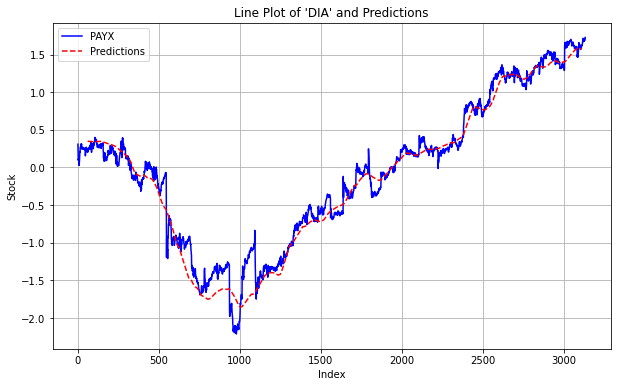

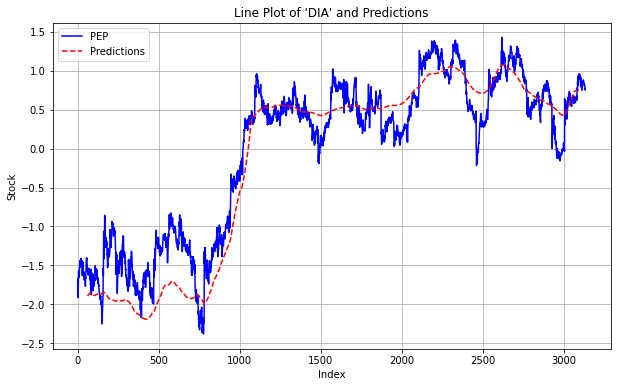

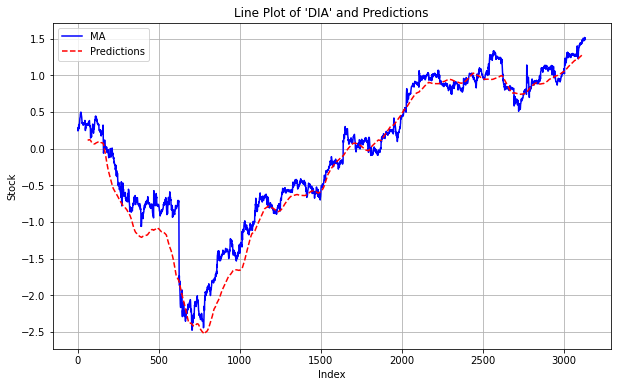

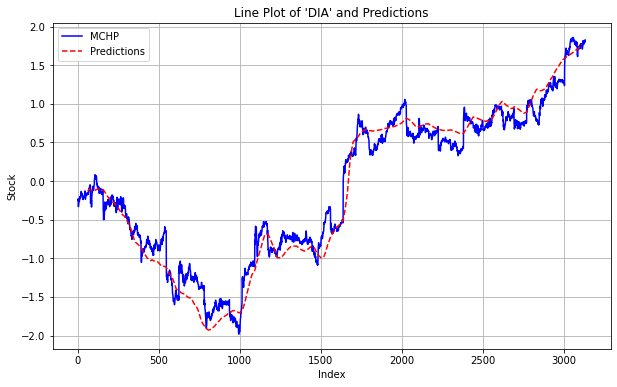

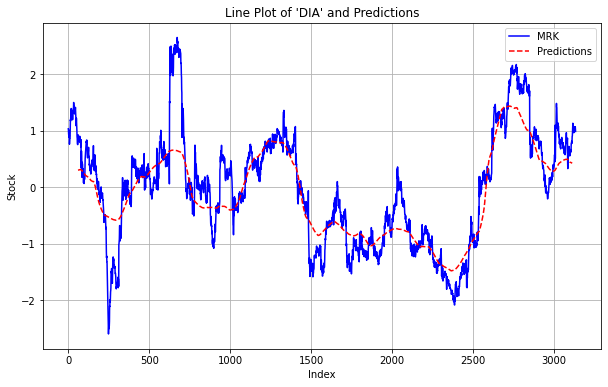

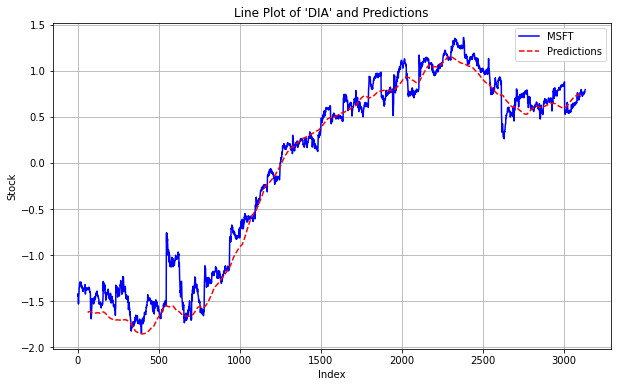

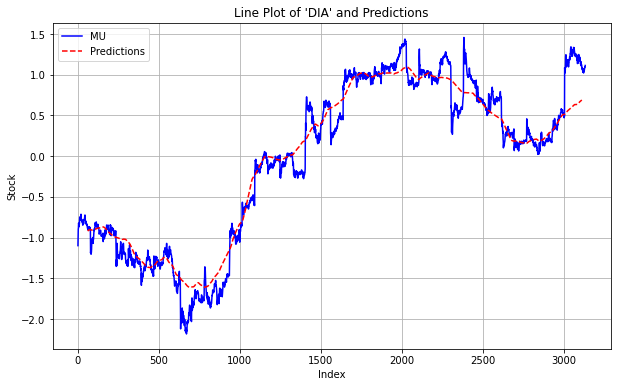

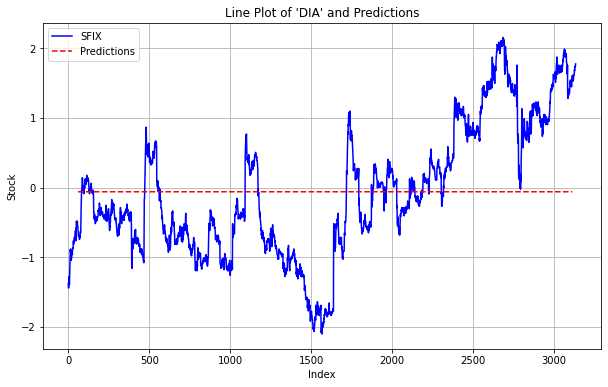

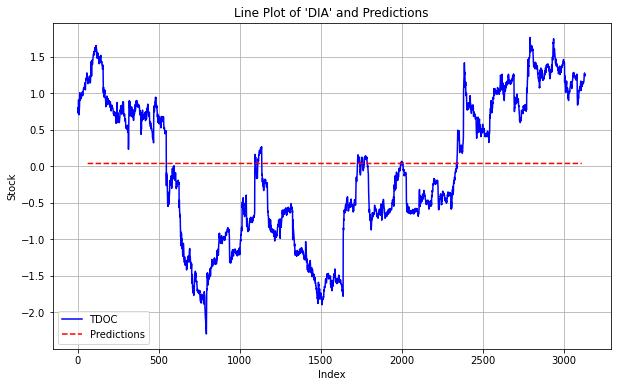

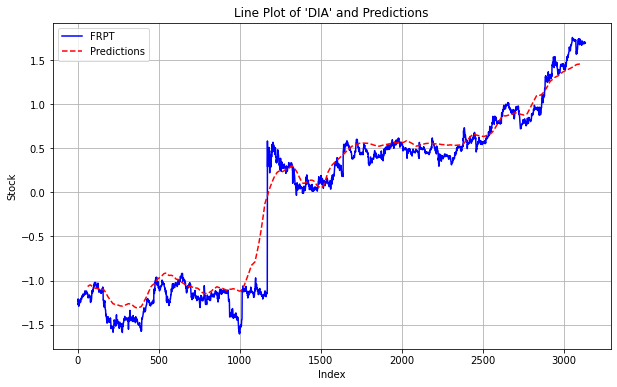

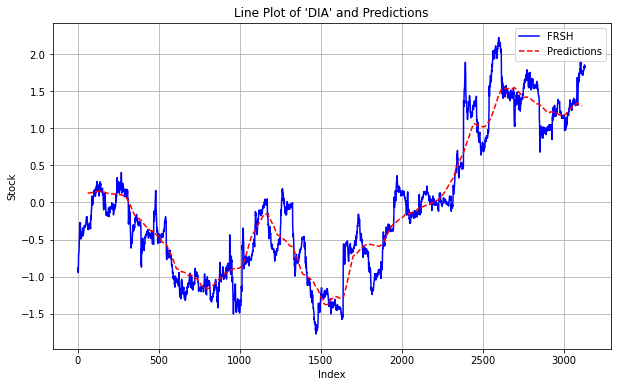

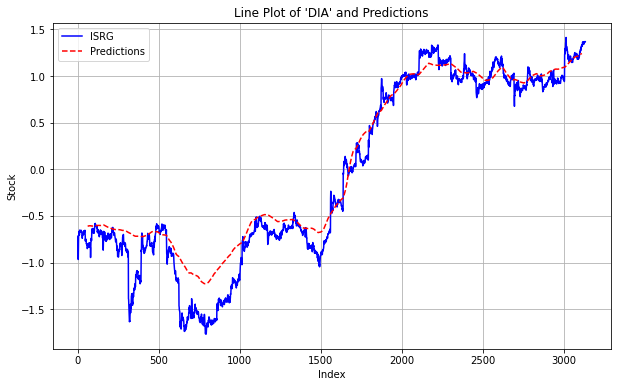

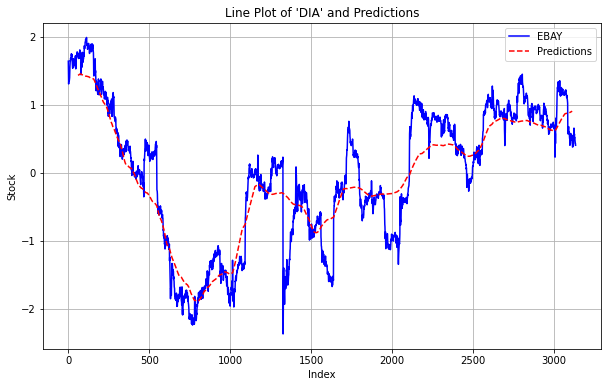

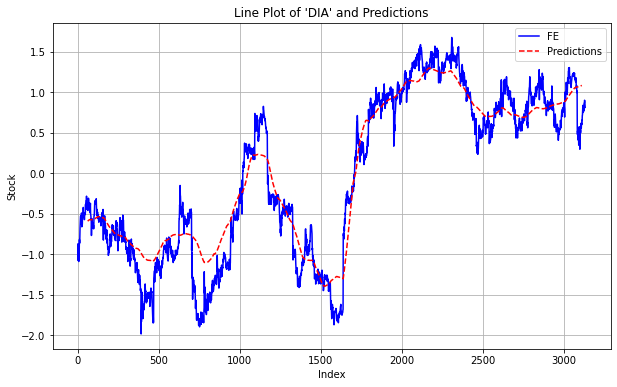

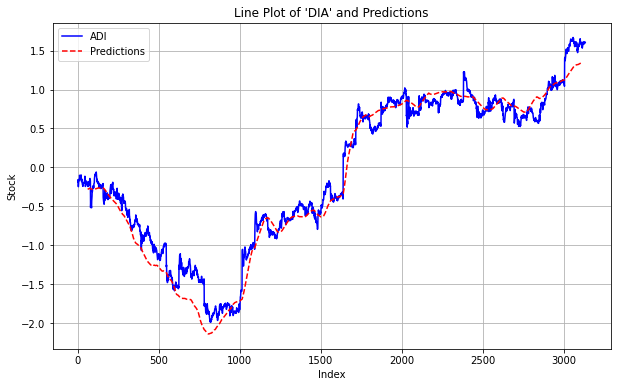

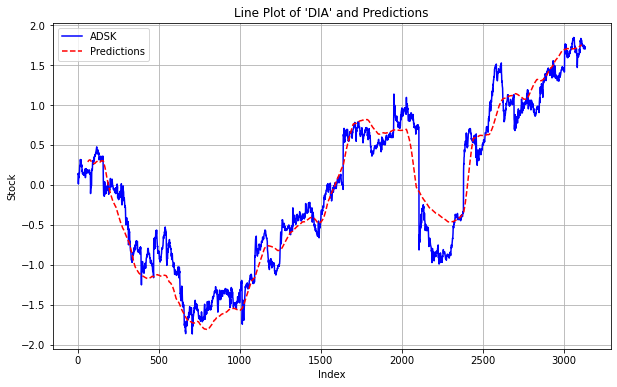

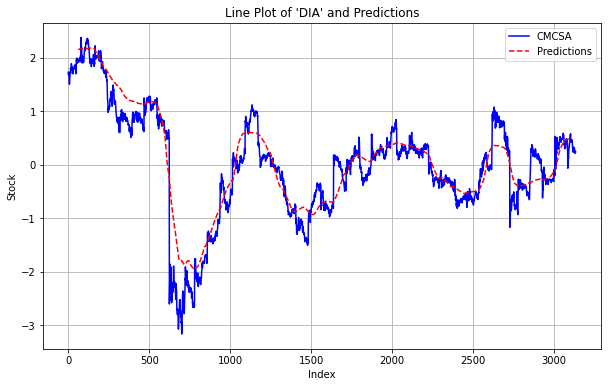

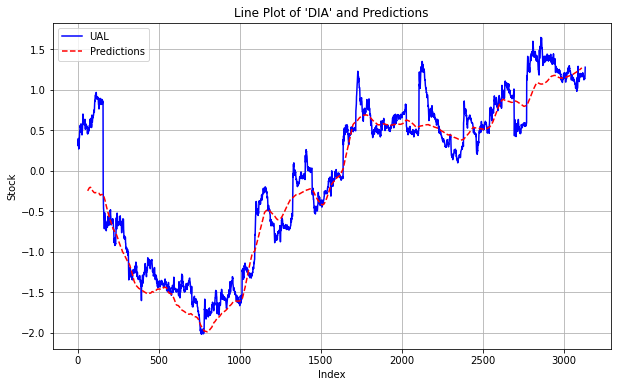

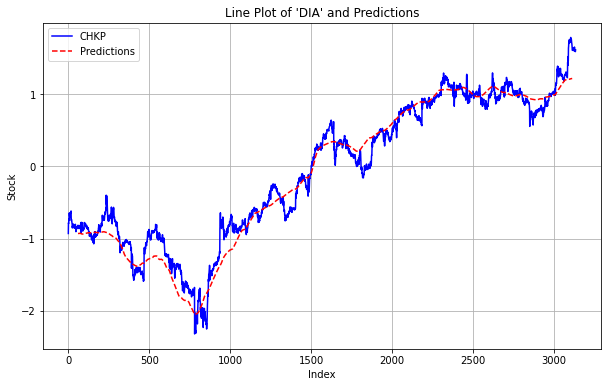

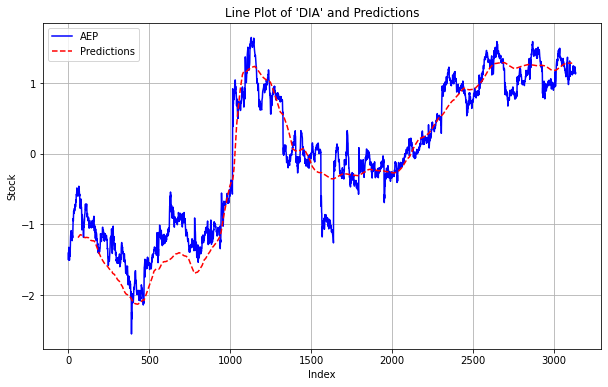

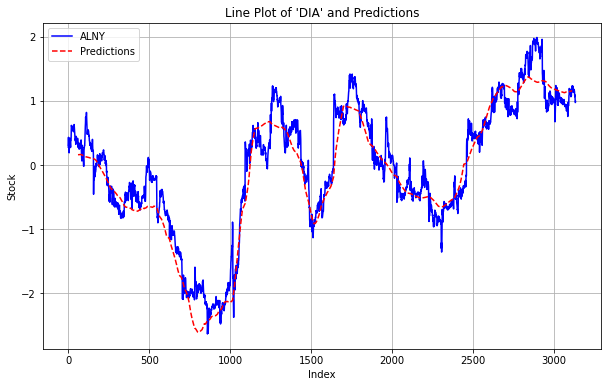

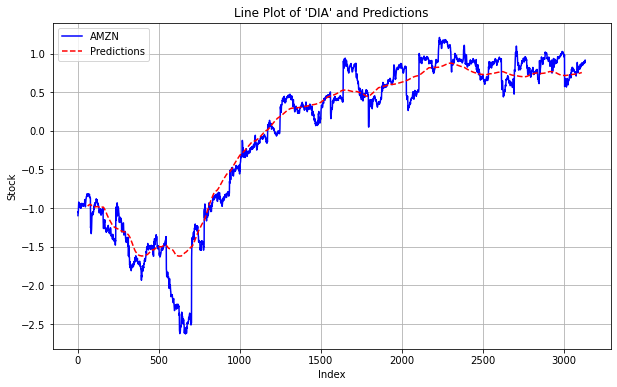

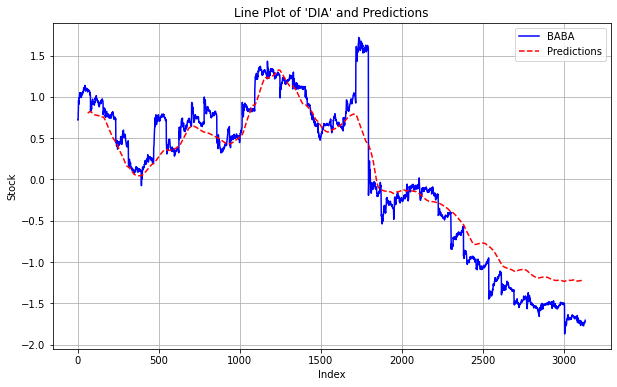

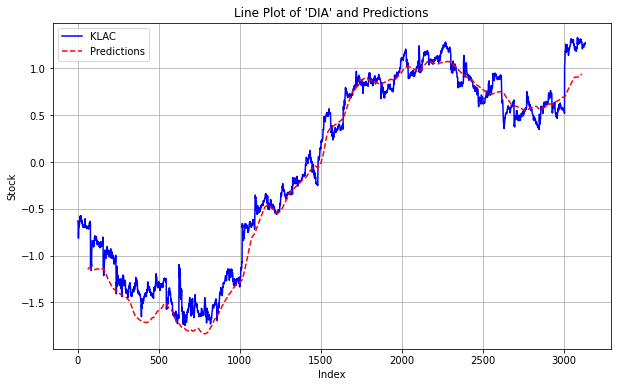

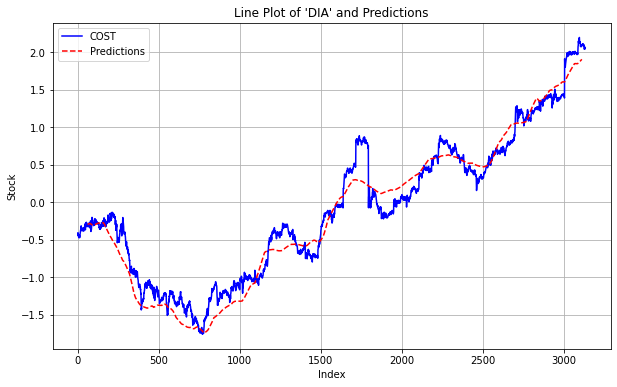

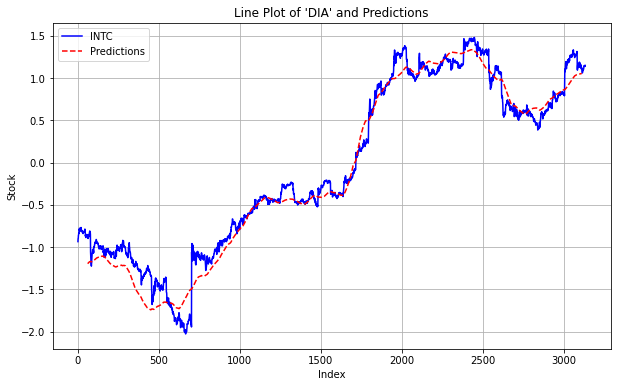

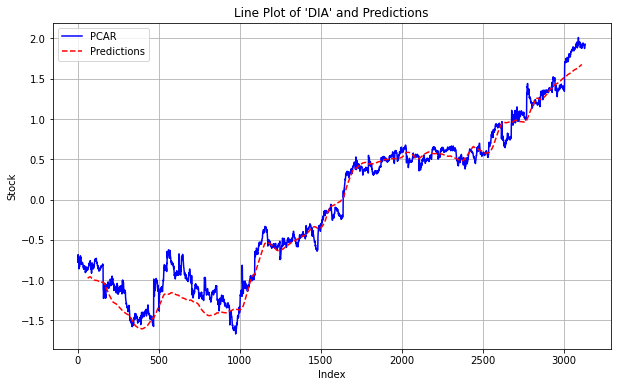

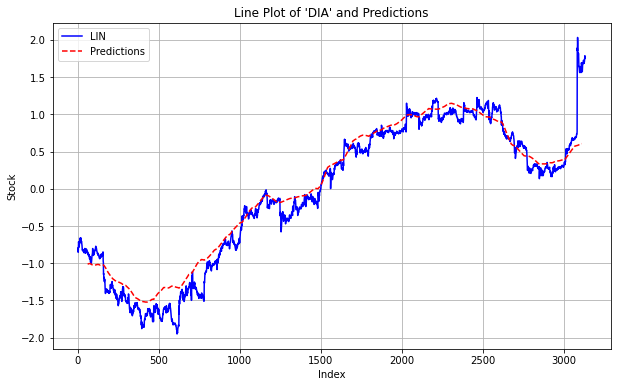

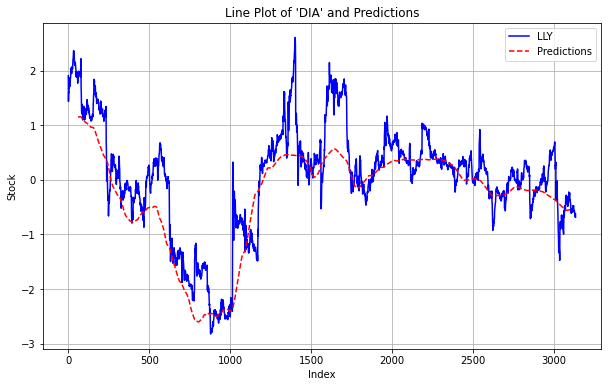

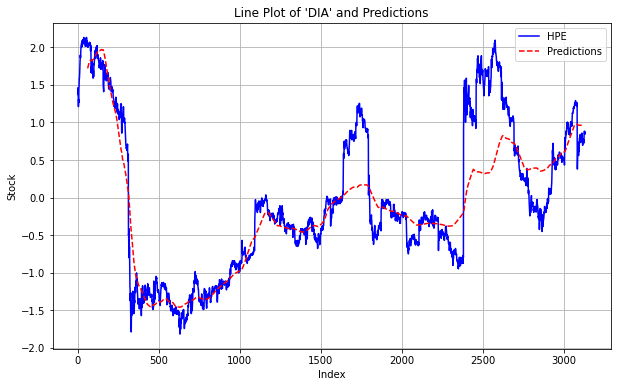

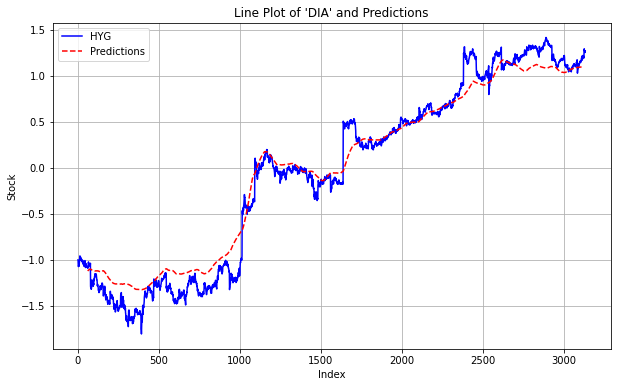

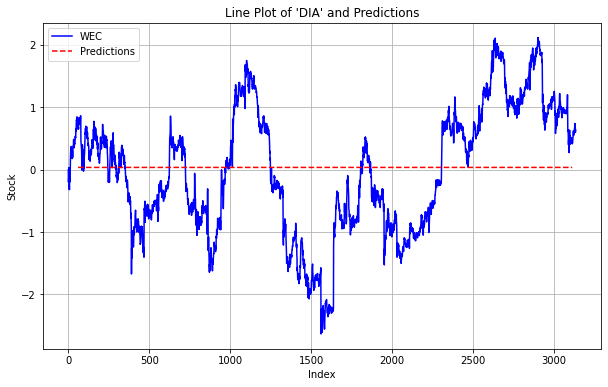

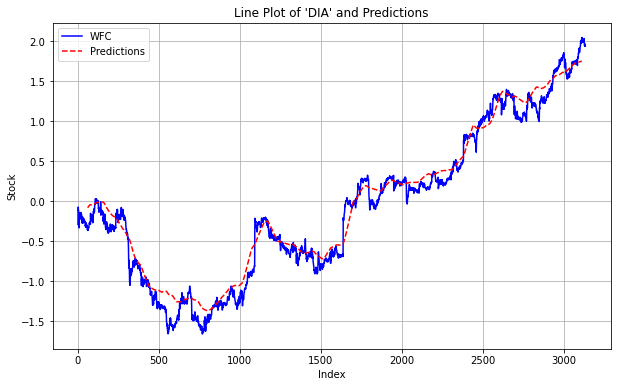

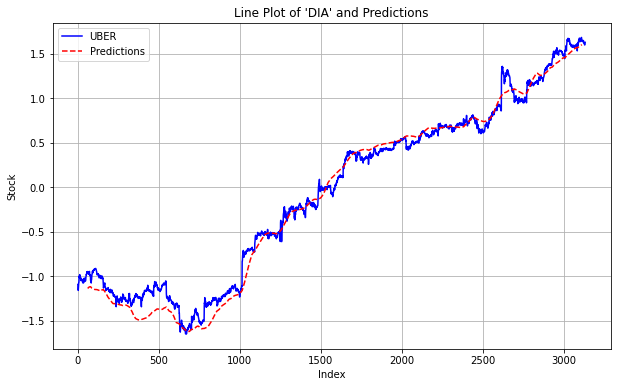

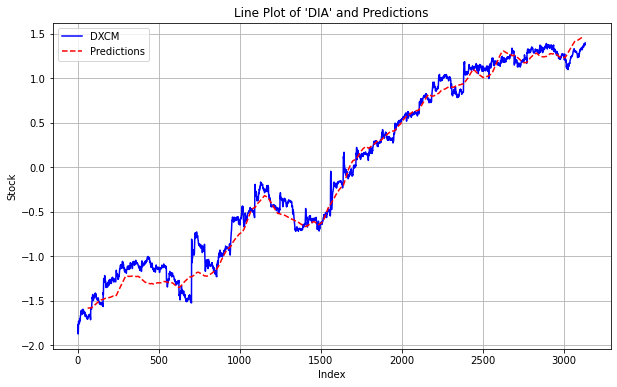

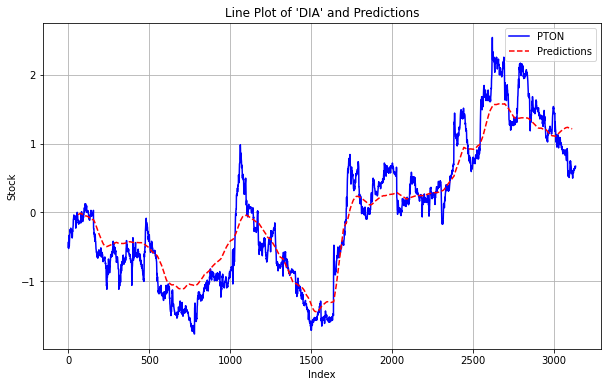

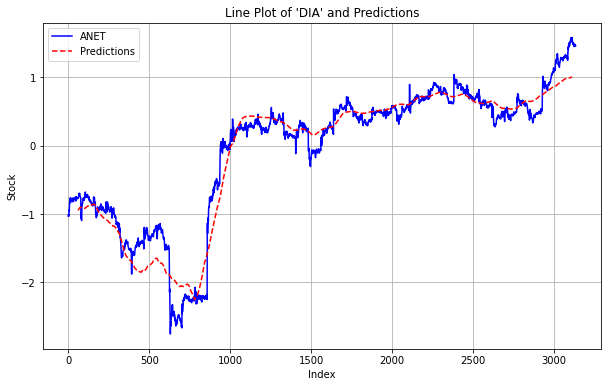

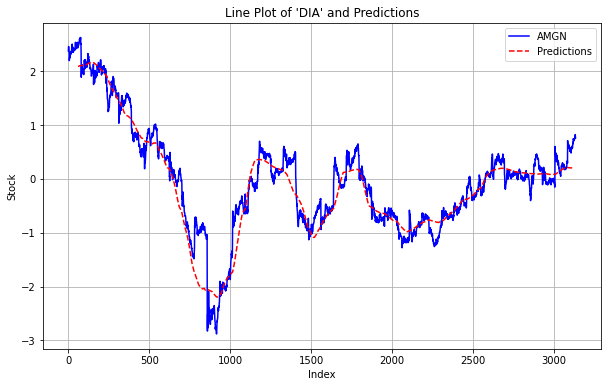

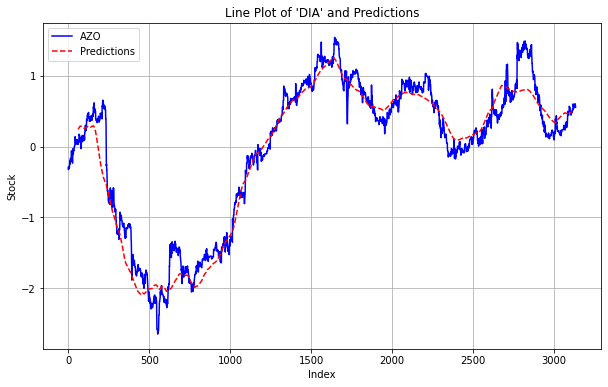

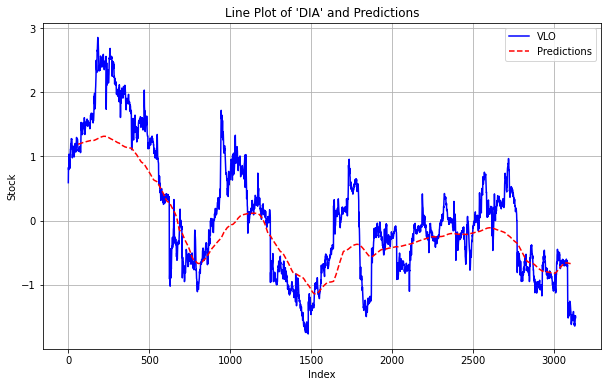

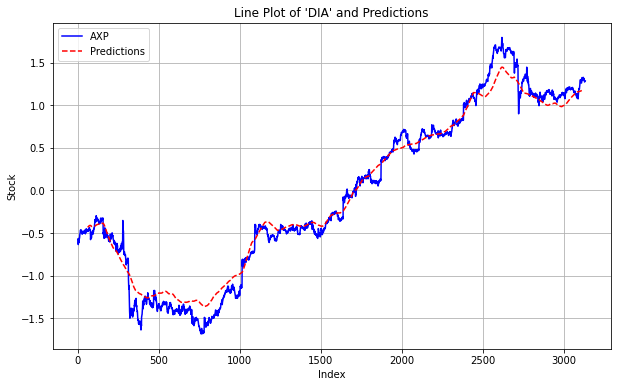

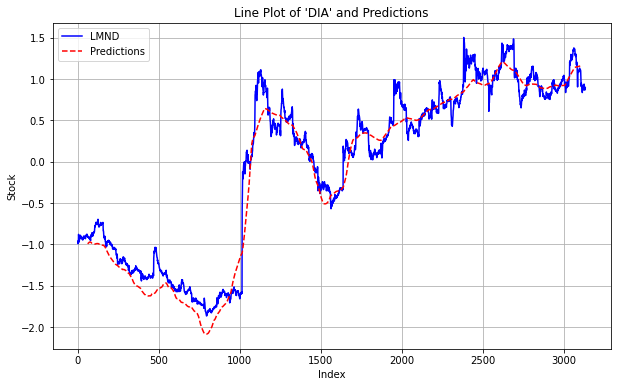

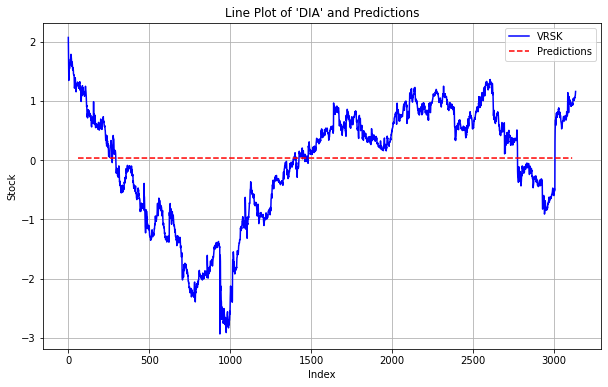

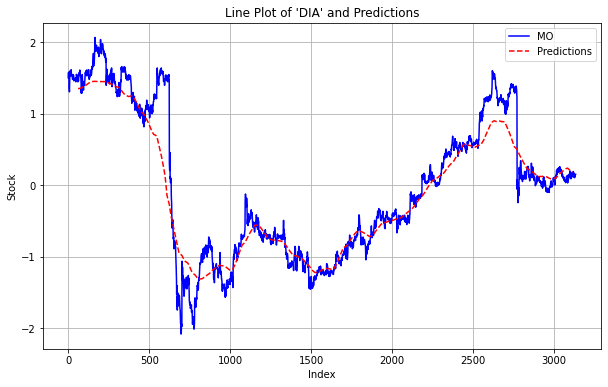

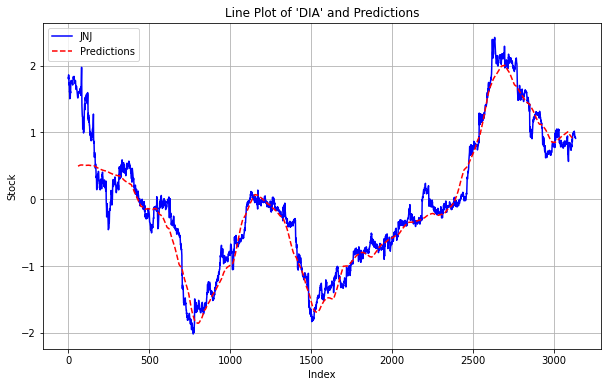

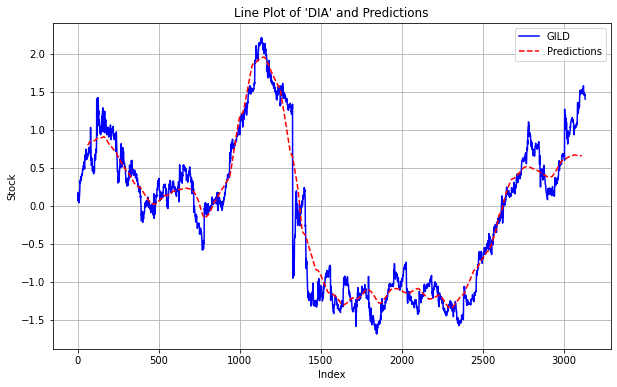

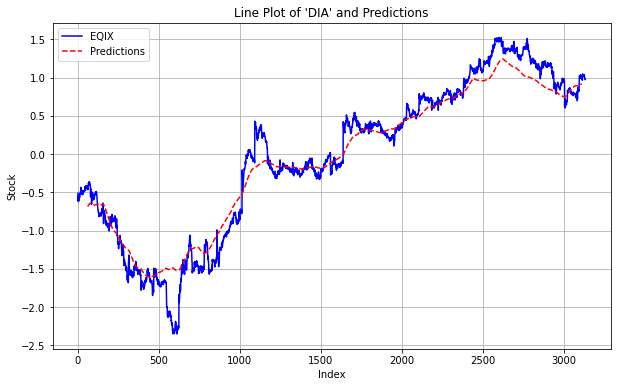

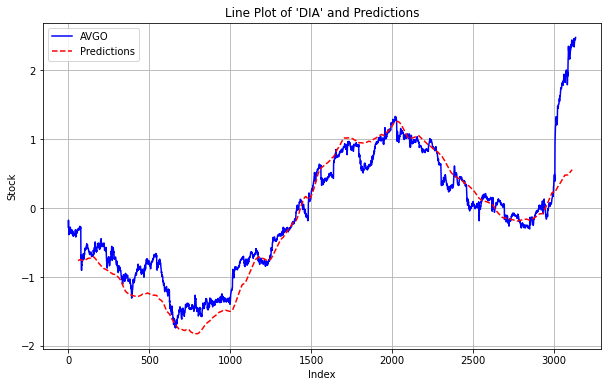

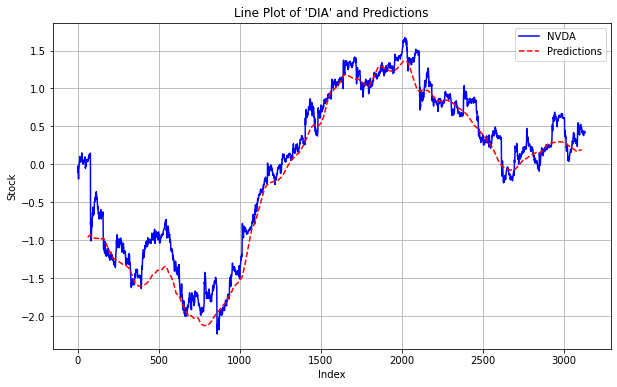

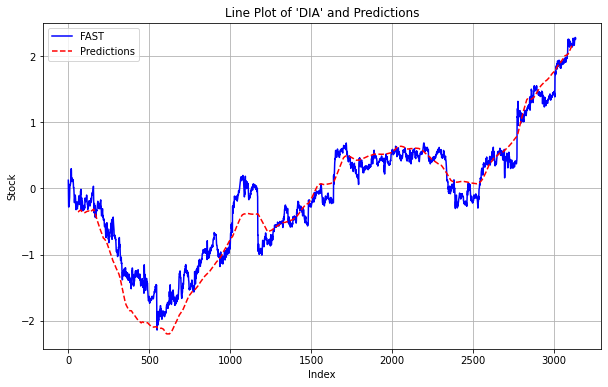

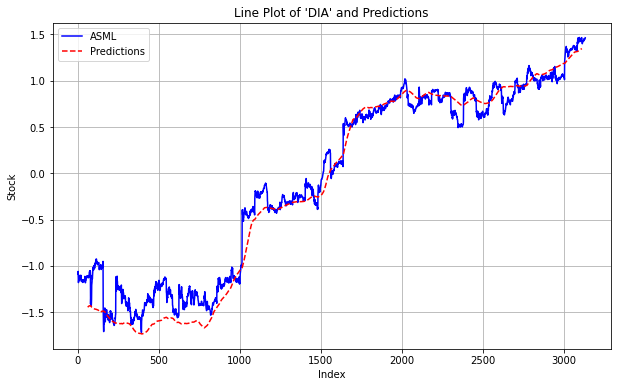

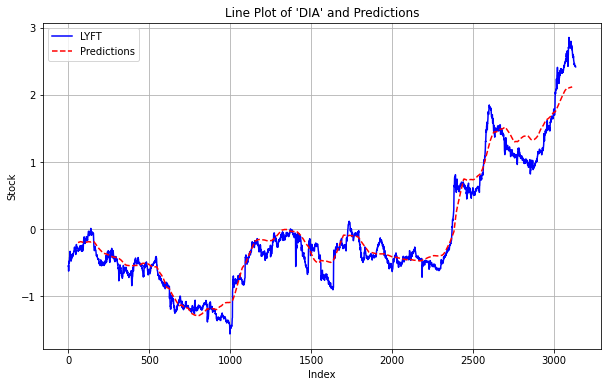

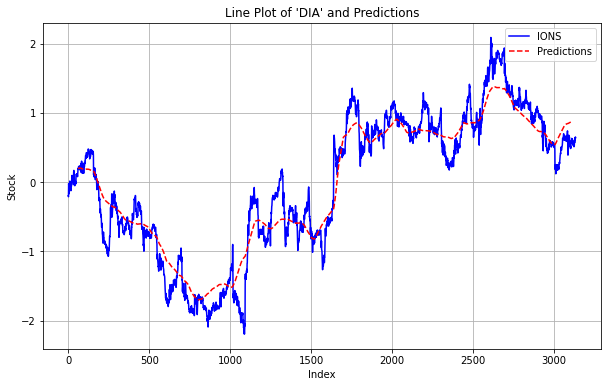

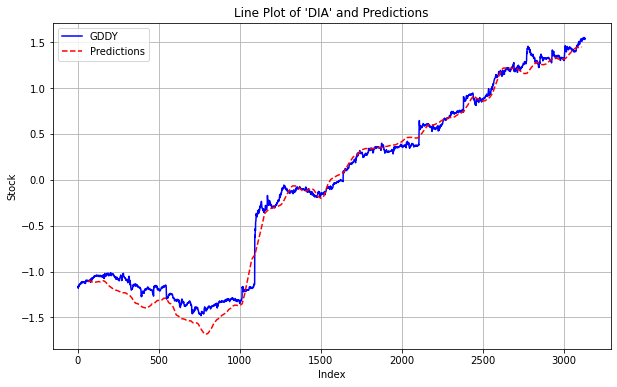

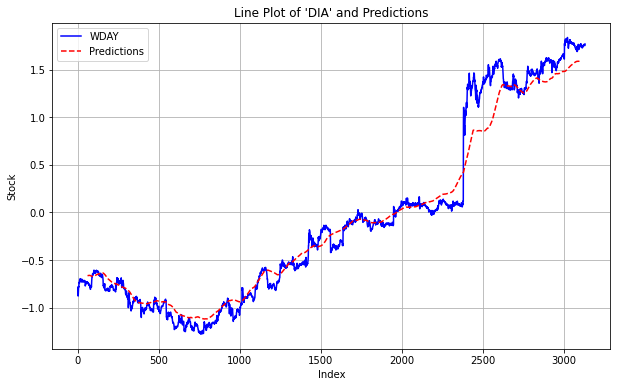

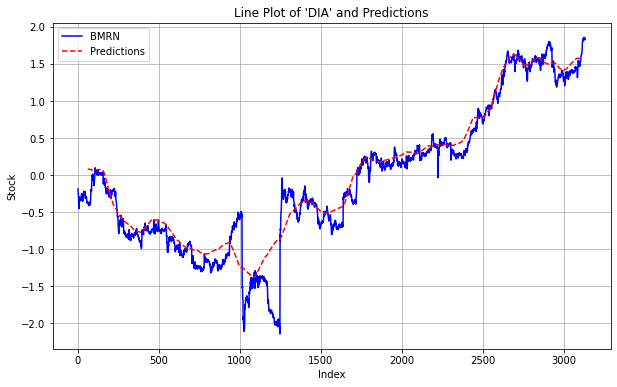

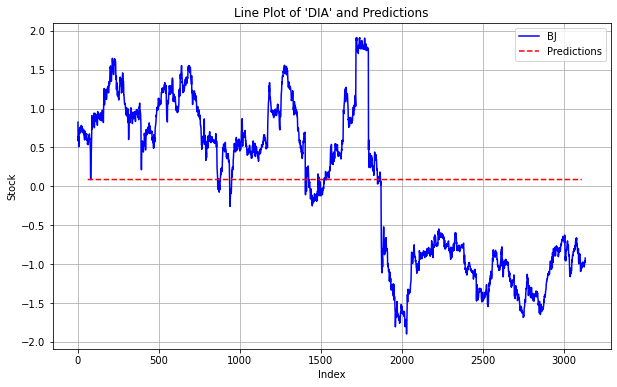

In [367]:
# for ticker in holding:
for ticker in holding:
    security = list(df_old.columns).index(ticker)
    model.load_state_dict(torch.load('C:/Users/ooo/tor/LSTM_production/Four_head_attention_MODELS/Quad_model_12_12_new_data_'+df_old.columns[security]+'_26_steps'))
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():  # No need to track gradients for inference
        for inputs, _ in new_dataloader:  # Assuming you don't need the targets for prediction
            inputs = inputs.to(device)
    
            # Forward pass to get outputs/predictions
            outputs = model(inputs)
            for single_out in outputs:
                predictions.append(single_out.cpu())

    plt.figure(figsize=(10, 6))
    
    # Plot original DIA data
    plt.plot(list(df_new[ticker]), label=ticker, color='blue')
    
    # Plot predictions
    # If predictions align with the entire df_source['DIA'] array
    x_values_for_predictions = range(82, 82 + len(predictions))
    
    plt.plot(x_values_for_predictions, predictions, label='Predictions', color='red', linestyle='--')
    
    # If predictions align with a specific window of the df_source['DIA'], you might need to adjust the x-axis
    # start_idx = ...
    # end_idx = start_idx + len(predictions)
    # plt.plot(range(start_idx, end_idx), predictions, label='Predictions', color='red', linestyle='--')
    
    plt.title("Line Plot of 'DIA' and Predictions")
    plt.xlabel("Index")
    plt.ylabel('Stock')
    plt.legend()
    plt.grid(True)
    plt.show()